In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***LIBRARIES***

In [ ]:
!pip install transformers accelerate safetensors torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82

In [3]:
!pip install transformers accelerate sentencepiece

***LLAVA MODEL***

In [1]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
import torch, gc
from PIL import Image
import requests
from transformers import LlavaProcessor

2025-07-19 20:56:13.462454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752958573.661527      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752958573.719844      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [43]:
def chatbot(image_path,user_info):
    model_id = "llava-hf/llava-1.5-7b-hf"

    model = LlavaForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
    ).to(0)

    processor = AutoProcessor.from_pretrained(model_id)

    torch.cuda.empty_cache()
    gc.collect()

    image = Image.open(image_path).convert("RGB")

    system_prompt = (
        "You are a friendly and creative fashion stylist working for a trendy online fashion platform like Myntra or Zara. "
        "Your job is to help users style a specific clothing item for a given occasion or mood.\n\n"
    
        "You'll be shown:\n"
        "- 🖼️ An image of a clothing item (like a top, dress, pants, etc.)\n"
        "- 🗣️ A short user prompt describing the event, time of day, desired look, or vibe\n\n"
    
        "🎯 Your task:\n"
        "Give detailed, practical, and fun styling advice that complements the outfit and suits the occasion. "
        "Keep the tone warm and encouraging.\n\n"
    
        "✅ Your answer *must* include:\n"
        "👖 Bottoms (with reasoning: contrast, comfort, occasion-fit, silhouette)\n"
        "👟 Footwear (mention at least two suitable styles)\n"
        "🧥 Outerwear or layering (if appropriate – like jackets, shrugs, or blazers,etc)\n"
        "💄 Makeup (only if suitable – day/night, glam vs soft,etc)\n"
        "💇 Hairstyle (match the vibe and practicality)\n"
        "💍 Accessories (2–4 pieces: earrings, necklaces, bags, belts, hair accessories, etc)\n"
        "☀️ Vibe Summary: (Summarize the aesthetic in 3–5 words)\n\n"
    
        "📝 Tips:\n"
        "- Be specific: Name fabric types (e.g., leather pants, cotton shorts), patterns (e.g., floral, satin), and colors.\n"
        "- Follow basic fashion balance rules: tight + loose pairings, bold + minimal, etc.\n"
        "- Consider context (club night, casual brunch, wedding, date, college fest, etc.)\n"
        "- Keep it practical and NOT too high fashion or inaccessible\n"
        "- Use emojis to make it lively 🌟\n\n"
    
        "🧠 Optional Guidelines:\n"
        "- For glam or party: Suggest sparkle, bold lipstick, dramatic eyes, heels\n"
        "- For daytime: Softer makeup, breathable fabrics, relaxed hairstyles\n"
        "- For edgy looks: Leather, bold cuts, dark lips, boots\n"
        "- For minimal looks: Clean lines, solid colors, delicate makeup, sleek hair\n\n"
    
        "🎨 Now analyze the image and user input and give complete styling advice using this format!"
    )




    conversation = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}],
        },
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": f"User info: {user_info}"},
            ],
        },
    ]

    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

    inputs = processor(images=image, text=prompt, return_tensors="pt").to(0, torch.float16)

    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=500)

    torch.cuda.empty_cache()
    gc.collect()

    response = processor.batch_decode(output[:, inputs["input_ids"].shape[-1]:], skip_special_tokens=True)[0]

    return response

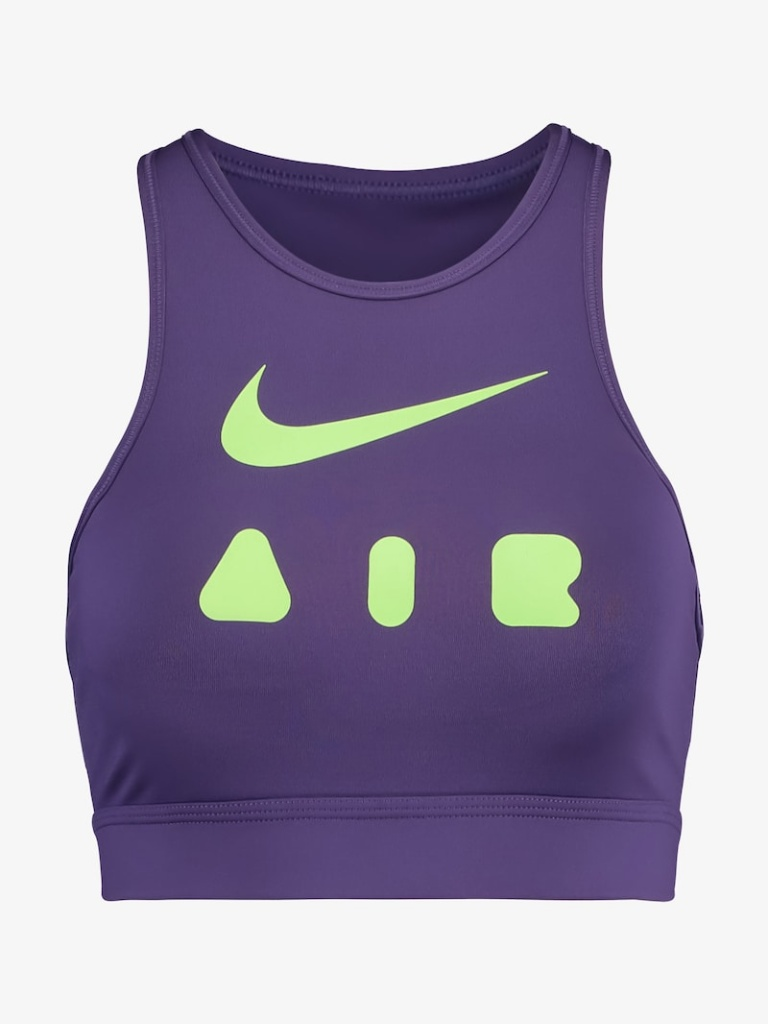

In [23]:
Image.open("/kaggle/input/fashion-bot-samples/sample_clothes/00461_00.jpg")

THE ***GIRLY-BOT/GLAMZILLA/OVERFIT/LOOK WHOS TALKING/TRY HARDER*** BOT

***WHAT THE FROCK! :P***

In [46]:
image_path = "/kaggle/input/trial-man/00120_00.jpg"
user_info = input("I'm your helpful fashion assistant!✨\I just need a quick vibe check — where are you planning to wear this and what kind of look do you want? 💕✨")

I'm your helpful fashion assistant!✨\I just need a quick vibe check — where are you planning to wear this and what kind of look do you want? 💕✨ I want to style this t shirt for a fest, as a guy, i dont knwo to style it


In [47]:
response = chatbot(image_path, user_info)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
print("🧠 Styling Advice:\n", response)

🧠 Styling Advice:
 🎉 Fest Vibe: Fun, laid-back, and comfortable

👖 Bottoms: Loose, casual, and breathable denim shorts
👟 Footwear: Sneakers or casual shoes to match the fest vibe
🧥 Outerwear: A lightweight, colorful cardigan or a denim jacket
💄 Makeup: Minimal, with a touch of colorful lip gloss
💇 Hairstyle: Short, messy, and easy to style
💍 Accessories: A colorful beaded necklace, a pair of statement earrings, and a wristband

☀️ Vibe Summary: A fun, laid-back, and comfortable look for a festive occasion.


***CLEARING GPU MEMORY***

In [33]:
import torch
import gc
for var in ['model', 'inputs', 'output', 'response', 'processor']:
    try:
        del globals()[var]
    except KeyError:
        pass
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()